In [34]:
import pandas as pd
import numpy as np
from IPython.display import Image
import plotly.express as px
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,BisectingKMeans,Birch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

## Dataset

In [35]:
input_file = "/content/clean.xlsx"
df = pd.read_excel(input_file)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229775 entries, 0 to 229774
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   region               229775 non-null  object 
 1   system               229775 non-null  object 
 2   parameter            229775 non-null  object 
 3   units                229775 non-null  object 
 4   health_guideline     229775 non-null  object 
 5   aesthetic_guideline  229182 non-null  object 
 6   average_value        226098 non-null  float64
 7   health_compliance    134453 non-null  object 
 8   disinfection         229775 non-null  object 
 9   end_date             229775 non-null  object 
 10  Comment              26136 non-null   object 
dtypes: float64(1), object(10)
memory usage: 19.3+ MB


In [37]:
df.head()

,region,system,parameter,units,health_guideline,aesthetic_guideline,average_value,health_compliance,disinfection,end_date,Comment
0,Eyre,Coffin Bay,Alkalinity,mg/L,NG,NG,237.0000,NaN,Chlorine,01/03/2021 - 28/02/2022,NaN
1,Eyre,Coffin Bay,Aluminium - acid soluble,mg/L,NG,≤ 0.2,0.0010,NaN,Chlorine,01/03/2021 - 28/02/2022,NaN
2,Eyre,Coffin Bay,Antimony,mg/L,≤ 0.003,NG,0.0005,100%,Chlorine,01/03/2021 - 28/02/2022,NaN
3,Eyre,Coffin Bay,Arsenic,mg/L,≤ 0.01,NG,0.0008,100%,Chlorine,01/03/2021 - 28/02/2022,NaN
4,Eyre,Coffin Bay,Barium,mg/L,≤ 2,NG,0.0167,100%,Chlorine,01/03/2021 - 28/02/2022,NaN


## Data Preparation


Mari kita check value parameter

In [38]:
df.parameter.unique()

array(['Alkalinity', 'Aluminium - acid soluble', 'Antimony', 'Arsenic',
       'Barium', 'Beryllium', 'Bicarbonate', 'Boron', 'Cadmium',
       'Calcium', 'Carbonate', 'Chloral hydrate', 'Chloride',
       'Chlorine (free residual)', 'Chloramine (mono residual)',
       'Chlorine (total residual)', 'Chloroacetic acid', 'Chromium',
       'Colour', 'Copper', 'Cyanide as CN', 'Dichloroacetic acid',
       'E. coli', 'Fluoride', 'Hardness', 'Iodide', 'Iron', 'Lanthanum',
       'Lead', 'Magnesium', 'Manganese', 'Mercury', 'Molybdenum',
       'Nickel', 'Nitrate + nitrite as NO3', 'Pentachlorophenol', 'pH',
       'Potassium', 'Selenium', 'Silica - reactive', 'Silver', 'Sodium',
       'Sulphate', 'Total dissolved solids', 'Trichloroacetic acid',
       'Trihalomethanes (THMs)', 'Turbidity', 'Uranium', 'Zinc',
       '2 4 6 Trichlorophenol', '2 4 Dichlorophenol', '2 Chlorophenol',
       'Hardness - English Degrees', 'Hardness - French Degrees',
       'Hardness - German Degrees', 'Hardnes

Dari Value Parameter ternyata, setiap sistem mempunyai parameter yang similiar.mari kita check health_guideline dan aesthetic_guideline berdasarkan value parameternya

In [39]:
result_df = df.groupby('parameter').agg({
    'health_guideline': 'first',
    'aesthetic_guideline': 'first',
    'units': 'first'
}).reset_index()
print(result_df)

                   parameter health_guideline aesthetic_guideline     units
0      2 4 6 Trichlorophenol             ≤ 20                 ≤ 2      µg/L
1         2 4 Dichlorophenol            ≤ 200               ≤ 0.3      µg/L
2             2 Chlorophenol            ≤ 300               ≤ 0.1      µg/L
3                 Alkalinity               NG                  NG      mg/L
4   Aluminium - acid soluble               NG               ≤ 0.2      mg/L
..                       ...              ...                 ...       ...
62    Trihalomethanes (THMs)            ≤ 250                  NG      µg/L
63                 Turbidity               NG                 ≤ 5       NTU
64                   Uranium           ≤ 0.02                  NG      mg/L
65                      Zinc               NG                 ≤ 3      mg/L
66                        pH               NG           6.5 - 8.5  pH units

[67 rows x 4 columns]


Ternyata setiap parameter mempunyai health_guideline,aesthetic_guideline, dan units yang sama. Maka untuk mempermudah clustering drop kolom health_guideline,aesthetic_guideline, dan units

In [40]:
df = df.drop(columns=['health_guideline', 'aesthetic_guideline','units'])

Check Unique Value health_compliance

In [41]:
df.health_compliance.unique()

array([nan, '100%', 'NG', '97.4%', '99.2%', '99.5%', '95.8%', '99.8%',
       '91.7%', '0%', 1, 0.892, 0.897, 0.984, 0.95, 0.583, 0.5, '91.9%',
       '92.8%', '98.4%', '95.0%', '58.3%', '66.7%', '97.7%', '99.9%',
       '94.4%', '88.5%', '99.7%', '75.0%', '50.0%', '84.6%', '83.3%',
       0.991, 0.944, 0.997, 0.8, 0, 0.333, 0.993, 0.996, 0.792, '97.5%',
       '95.5%', '76.9%', 0.999, 0.917, 0.708, '87.5%', '99.0%', '92.3%',
       '92.1%', '97.2%', '72.7%', '61.5%', 0.914, 0.874, 0.667, 0.919,
       0.906, 0.998, 0.947, '82.9%', '90.9%', '98.1%', '71.9%', '68.8%',
       '94.7%', '92.9%', '93.2%', '99.1%', '88.9%', 0.974, 0.985, 0.988,
       0.88, 0.652, '91.4%', '86.0%', '7.1%', '33.3%', '99.3%', '83.6%',
       '80.0%', 0.886, 0.865, 0.2, 0.75, '99.4%', 0.862, 0.912, 0.851,
       0.994, 0.973, 0.907, 0.983, 0.833, 0.941, 0.842, 0.25, '99.6%',
       '98.3%', '98.5%', '98.8%', '87.3%', '86.8%', '67.7%', '94.1%',
       '88.0%', '88.1%', '96.0%', '93.3%', '93.0%', '85.9%', '85.7%'

terdapat nilai NG yang berarti No Guideline maka drop health_compliance yang bernilai NG

In [42]:
df = df[df['health_compliance'] != 'NG']

Lalu samakan data dengan mengubah persen ke desimal dengan rasio
0 - 1. dan menghapus persen

In [43]:
# Assuming your DataFrame is named df
import pandas as pd

# Function to convert percentage to decimal
def convert_percentage_to_decimal(percentage):
    if isinstance(percentage, str) and '%' in percentage:
        return float(percentage.strip('%')) / 100
    else:
        return percentage

# Apply the function to the 'health_compliance' column
df['health_compliance'] = df['health_compliance'].apply(convert_percentage_to_decimal)

<ipython-input-43-dbf806d7bd90>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['health_compliance'] = df['health_compliance'].apply(convert_percentage_to_decimal)


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206759 entries, 0 to 229770
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   region             206759 non-null  object 
 1   system             206759 non-null  object 
 2   parameter          206759 non-null  object 
 3   average_value      204226 non-null  float64
 4   health_compliance  111437 non-null  float64
 5   disinfection       206759 non-null  object 
 6   end_date           206759 non-null  object 
 7   Comment            24148 non-null   object 
dtypes: float64(2), object(6)
memory usage: 14.2+ MB


Terdapat nilai null pada average_value dan health_compliance. Maka dari itu kita isi dengan mean bertipe parameter yang sama

In [45]:
df['average_value'] = df.groupby('parameter')['average_value'].transform(lambda x: x.fillna(x.mean()))

In [46]:
df['health_compliance'] = df.groupby('parameter')['health_compliance'].transform(lambda x: x.fillna(x.mean()))

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206759 entries, 0 to 229770
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   region             206759 non-null  object 
 1   system             206759 non-null  object 
 2   parameter          206759 non-null  object 
 3   average_value      206759 non-null  float64
 4   health_compliance  111651 non-null  float64
 5   disinfection       206759 non-null  object 
 6   end_date           206759 non-null  object 
 7   Comment            24148 non-null   object 
dtypes: float64(2), object(6)
memory usage: 14.2+ MB


Ternyata masih ada nilai health_compliance yang berisi null dan tidak ada nilainya maka dari itu kita drop nilai null

In [48]:
df = df.dropna(subset=['health_compliance'])

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111651 entries, 2 to 229770
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   region             111651 non-null  object 
 1   system             111651 non-null  object 
 2   parameter          111651 non-null  object 
 3   average_value      111651 non-null  float64
 4   health_compliance  111651 non-null  float64
 5   disinfection       111651 non-null  object 
 6   end_date           111651 non-null  object 
 7   Comment            13129 non-null   object 
dtypes: float64(2), object(6)
memory usage: 7.7+ MB


Drop Kolom Comment karena tidak mempengaruhi clustering

In [50]:
df = df.drop(columns=['Comment'])

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111651 entries, 2 to 229770
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   region             111651 non-null  object 
 1   system             111651 non-null  object 
 2   parameter          111651 non-null  object 
 3   average_value      111651 non-null  float64
 4   health_compliance  111651 non-null  float64
 5   disinfection       111651 non-null  object 
 6   end_date           111651 non-null  object 
dtypes: float64(2), object(5)
memory usage: 6.8+ MB


In [52]:
df.system.unique()

array(['Coffin Bay', 'Elliston', 'Eyre South', 'Eyre South/Morgan ',
       'Morgan/Eyre', 'Anstey Hill (supplying north eastern Adelaide)',
       'Barossa (supplying Gawler and surrounds)',
       'Central metro Adelaide suburbs', 'Eastern metro Adelaide suburbs',
       'Myponga metro (supplying outer southern Adelaide)',
       'Northern metro Adelaide suburbs',
       'Southern metro Adelaide suburbs',
       'Western metro Adelaide suburbs', 'Barmera ', 'Berri ',
       'Blanchetown ', 'Cadell ', 'Glossop ', 'Leigh Creek ', 'Loxton ',
       'Melrose', 'Moorook ', 'Morgan/Northern', 'Morgan/Swan Reach ',
       'Parachilna', 'Quorn', 'Renmark ', 'Waikerie ', 'Wilmington',
       'Woolpunda ', 'Barossa ', 'Cowirra ', 'Happy Valley ', 'Hawker',
       'Kanmantoo ', 'Mannum ', 'Middle River ', 'Mt Compass',
       'Mt Pleasant ', 'Murray Bridge ', 'Mypolonga ',
       'Myponga (supplying Victor Harbor and the Fleurieu)',
       'Myponga, Yankalilla, Normanville and Carrickalinga', '

In [53]:
df.head()

,region,system,parameter,average_value,health_compliance,disinfection,end_date
2,Eyre,Coffin Bay,Antimony,0.0005,1.0,Chlorine,01/03/2021 - 28/02/2022
3,Eyre,Coffin Bay,Arsenic,0.0008,1.0,Chlorine,01/03/2021 - 28/02/2022
4,Eyre,Coffin Bay,Barium,0.0167,1.0,Chlorine,01/03/2021 - 28/02/2022
5,Eyre,Coffin Bay,Beryllium,0.0003,1.0,Chlorine,01/03/2021 - 28/02/2022
7,Eyre,Coffin Bay,Boron,0.2060,1.0,Chlorine,01/03/2021 - 28/02/2022


Semua Data sudah Terisi dan tidak ada bernilai Null

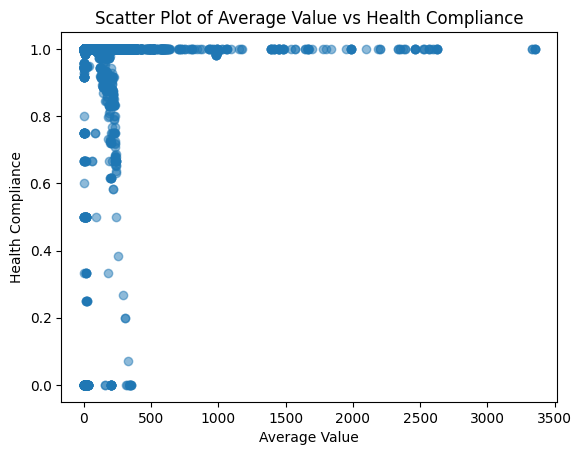

In [54]:
plt.scatter(df['average_value'], df['health_compliance'], alpha=0.5)
plt.title('Scatter Plot of Average Value vs Health Compliance')
plt.xlabel('Average Value')
plt.ylabel('Health Compliance')
plt.show()

## K-Means Clustering


Kita akan menggunakan kolom health_compliance dan average_value, karena value tersebut berpengaruh terhadap kualitas air

Sebelum itu kita Cari nilai K yang paling optimum untuk K-Means Clustering dengan Elbow Method

Kita juga gunakan MinMaxScaler untuk standarisasi fitur yang akan digunakan

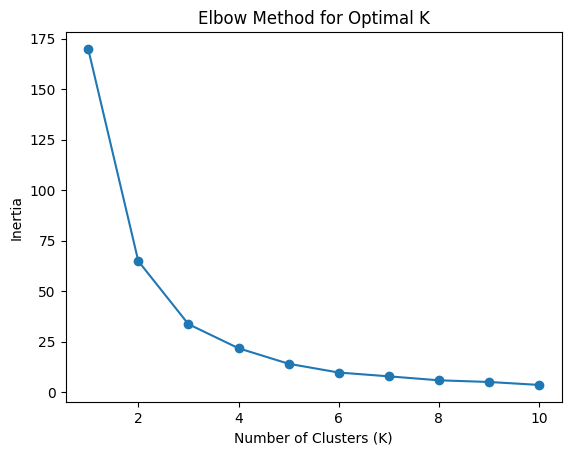

In [55]:
kmdf = df
inertia_values = []

# Pilih kolom yang akan digunakan untuk clustering
columns_for_clustering = ['average_value', 'health_compliance']

# Lakukan standardization pada fitur yang akan digunakan untuk clustering
scaler = MinMaxScaler()
kmdf[columns_for_clustering] = scaler.fit_transform(kmdf[columns_for_clustering])

# Pilih fitur-fitur yang akan digunakan untuk clustering
features_for_clustering = kmdf[columns_for_clustering]


# Coba nilai k dari 1 hingga 10 (misalnya)
for k in range(1, 11):
    kmeans = KMeans(n_init='auto', n_clusters=k, random_state=42)
    kmeans.fit(features_for_clustering)
    inertia_values.append(kmeans.inertia_)

# Plot grafik inersia
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


Dari Grafik Elbow Method didapat bahwa Nilai K yang paling optimum adalah 3

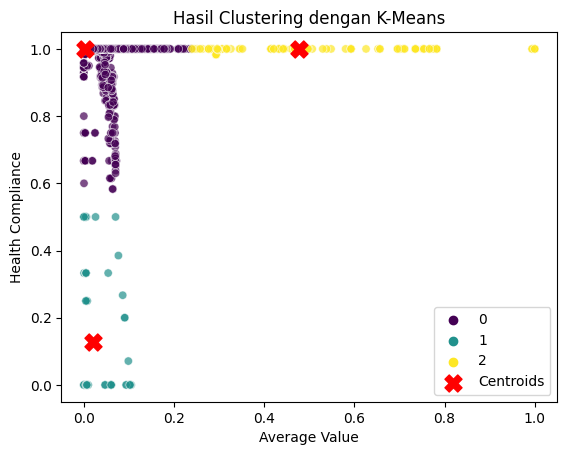

In [65]:
kmdf = df
K = 3
# Pilih kolom yang akan digunakan untuk clustering
columns_for_clustering = ['average_value', 'health_compliance']

# Lakukan standardization pada fitur yang akan digunakan untuk clustering
scaler = MinMaxScaler()
kmdf[columns_for_clustering] = scaler.fit_transform(kmdf[columns_for_clustering])

# Pilih fitur-fitur yang akan digunakan untuk clustering
features_for_clustering = kmdf[columns_for_clustering]

# Lakukan clustering dengan K-Means
kmeans = KMeans(n_init='auto',n_clusters=K, random_state=42)
kmdf['cluster'] = kmeans.fit_predict(features_for_clustering)

# Plot hasil clustering
sns.scatterplot(x='average_value', y='health_compliance', data=kmdf, hue='cluster', palette='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=150, label='Centroids')
plt.title('Hasil Clustering dengan K-Means')
plt.xlabel('Average Value')
plt.ylabel('Health Compliance')
plt.legend()
plt.show()

Hasil yang didapatkan dengan menggunakan clustering metode K-Means dengan k=3 menghasilkan hasil yang baik, dengan menggunakan 2 pasangan kelas yaitu **average_value** dan **health_compliance** juga didapatkan hasil yang lebih baik dari sebelumnya. Setiap cluster memiliki jarak yang tidak terlalu besar dan nilai yang didapat hampir sama.

In [66]:
# Filter DataFrame untuk cluster 0
cluster_0_sistem = kmdf[kmdf['cluster'] == 0]['system'].unique()

# Tampilkan hasil
print(cluster_0_sistem)

['Coffin Bay' 'Elliston' 'Eyre South' 'Eyre South/Morgan ' 'Morgan/Eyre'
 'Anstey Hill (supplying north eastern Adelaide)'
 'Barossa (supplying Gawler and surrounds)'
 'Central metro Adelaide suburbs' 'Eastern metro Adelaide suburbs'
 'Myponga metro (supplying outer southern Adelaide)'
 'Northern metro Adelaide suburbs' 'Southern metro Adelaide suburbs'
 'Western metro Adelaide suburbs' 'Barmera ' 'Berri ' 'Blanchetown '
 'Cadell ' 'Glossop ' 'Leigh Creek ' 'Loxton ' 'Melrose' 'Moorook '
 'Morgan/Northern' 'Morgan/Swan Reach ' 'Parachilna' 'Quorn' 'Renmark '
 'Waikerie ' 'Wilmington' 'Woolpunda ' 'Barossa ' 'Cowirra '
 'Happy Valley ' 'Hawker' 'Kanmantoo ' 'Mannum ' 'Middle River '
 'Mt Compass' 'Mt Pleasant ' 'Murray Bridge ' 'Mypolonga '
 'Myponga (supplying Victor Harbor and the Fleurieu)'
 'Myponga, Yankalilla, Normanville and Carrickalinga' 'Palmer '
 'Penneshaw ' 'Summit ' 'Swan Reach ' 'Swan Reach Town ' 'Wirrina Cove '
 'Amata' 'Davenport' 'Gerard' 'Indulkana' 'Kalka' 'Kaltjiti

In [67]:
# Filter DataFrame untuk cluster 1
cluster_1_sistem = kmdf[kmdf['cluster'] == 1]['system'].unique()

# Tampilkan hasil
print(cluster_1_sistem)

['Gerard' 'Nepabunna' 'Oak Valley' 'Pukatja' 'Wirrina Cove ' 'Kanpi'
 'Murputja' 'Nyapari']


In [68]:
# Filter DataFrame untuk cluster 2
cluster_2_sistem = kmdf[kmdf['cluster'] == 2]['system'].unique()

# Tampilkan hasil
print(cluster_2_sistem)

['Eyre South' 'Eyre South/Morgan ' 'Melrose' 'Wilmington' 'Penneshaw '
 'Amata' 'Kalka' 'Kaltjiti' 'Mimili' 'Murputja' 'Nepabunna' 'Oak Valley'
 'Pipalyatjara' 'Umuwa' 'Watinuma' 'Mt Gambier' 'Nangwarry' 'Naracoorte'
 'Port MacDonnell' 'Elliston' 'Quorn' 'Summit ' 'Barossa '
 'Myponga (supplying Victor Harbor and the Fleurieu)' 'Swan Reach '
 'Coffin Bay']


berdasarkan Hasil Clustering, dapat dilihat sistem yang memiliki cluster 1 ( nilai **Health Compliance** yang cukup rendah) sehingga dapat disimpulkan banyak sistem yang memiliki kualitas air yang baik dan terjaga

In [74]:
# Count occurrences of systems in each cluster
system_counts = kmdf[kmdf['cluster'].isin([2, 1, 0])]['system'].value_counts()

# Display the ranking
system_counts.head()


Renmark         1514
Moorook         1514
Parilla         1514
Cadell          1514
Blanchetown     1514
Name: system, dtype: int64

In [76]:
system_counts.tail()

Kanpi                   110
Oodnadatta              102
Hawker Desalination      90
Orroroo                  74
Warooka                  15
Name: system, dtype: int64

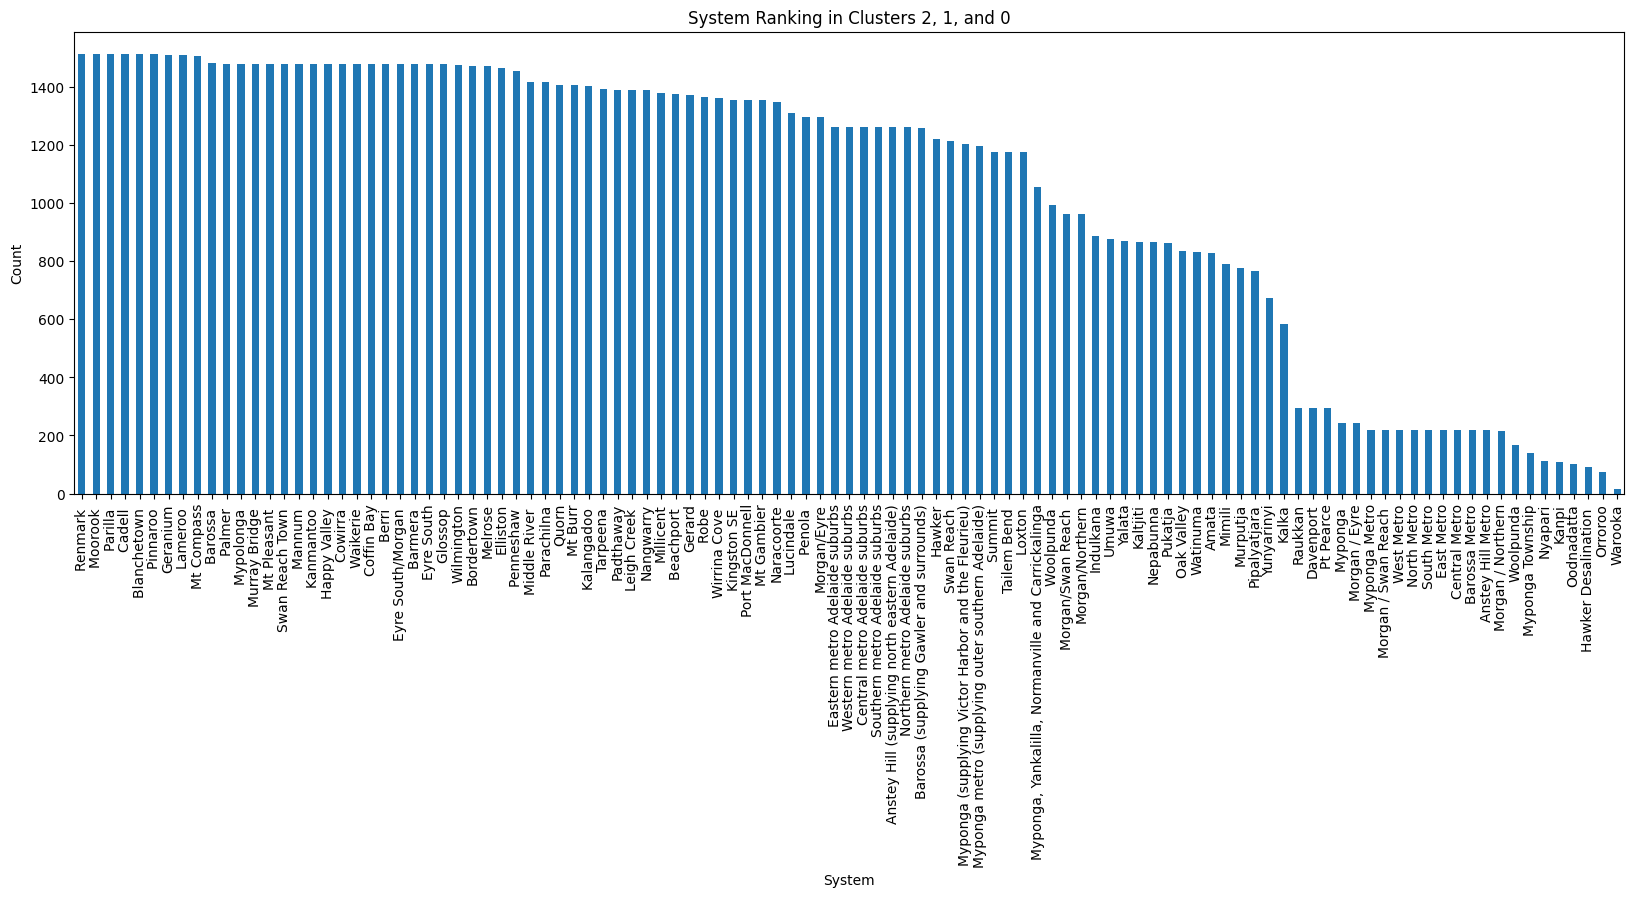

In [75]:
# Plot the ranking
system_counts.plot(kind='bar',figsize=(20, 6))
plt.title('System Ranking in Clusters 2, 1, and 0')
plt.xlabel('System')
plt.ylabel('Count')
plt.show()

Grafik diatas adalah Rangking System dengan urutan cluster 2,1,0 (dari Health Compliance dan Average Value tertinggi sampai terendah)

Dalam analisis ini, kami menghitung jumlah kemunculan setiap sistem dalam tiga cluster (cluster 2, 1, dan 0) dari DataFrame. Berikut adalah hasil peringkat lima sistem dengan jumlah kemunculan tertinggi:



1.   Renmark: Sistem ini muncul sebanyak 1514 kali dalam cluster yang dianalisis.
2.   Moorook: Juga muncul sebanyak 1514 kali, memiliki jumlah kemunculan yang sama dengan Renmark.
3.   Parilla: Sama seperti Renmark dan Moorook, Parilla juga muncul sebanyak 1514 kali.
4.   Cadell: Dengan jumlah kemunculan 1514, Cadell memiliki peringkat yang sama dengan sistem sebelumnya.
5.   Blanchetown: Seperti sistem sebelumnya, Blanchetown juga muncul sebanyak 1514 kali dalam cluster yang dianalisis.

Dan Jumlah kemunculan terendah dalam cluster yang dianalisis:

1.   Kanpi: Sistem ini muncul 110 kali dalam cluster.
2.   Oodnadatta: Muncul 102 kali dalam cluster.
3.   Hawker Desalination: Dengan 90 kemunculan.
4.   Orroroo: Memiliki jumlah kemunculan sebanyak 74 kali dalam cluster.
5.   Warooka: Sistem ini memiliki jumlah kemunculan terendah, yaitu 15 kali dalam cluster.

Analisis ini memberikan pemahaman tentang sebaran sistem-sistem dengan jumlah kemunculan terendah dalam cluster-cluster tertentu. Sistem-sistem ini mungkin memiliki karakteristik atau pola yang berbeda dibandingkan dengan sistem-sistem yang memiliki jumlah kemunculan lebih tinggi. Penelitian lebih lanjut dapat dilakukan untuk memahami faktor-faktor yang memengaruhi penempatan sistem-sistem ini dalam cluster-cluster tersebut.

# K-Means++ Clustering

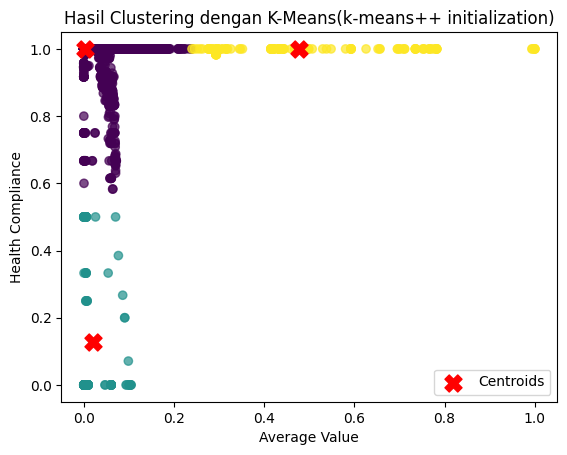

In [60]:
kmdf = df
K = 3
# Pilih kolom yang akan digunakan untuk clustering
columns_for_clustering = ['average_value', 'health_compliance']

# Lakukan standardization pada fitur yang akan digunakan untuk clustering
scaler = MinMaxScaler()
kmdf[columns_for_clustering] = scaler.fit_transform(kmdf[columns_for_clustering])

# Pilih fitur-fitur yang akan digunakan untuk clustering
features_for_clustering = kmdf[columns_for_clustering]

# Lakukan clustering dengan K-Means using k-means++ initialization
kmeans = KMeans(n_init='auto',init='k-means++',n_clusters=K, random_state=42)
kmdf['cluster'] = kmeans.fit_predict(features_for_clustering)

# Plot hasil clustering
plt.scatter(kmdf['average_value'], kmdf['health_compliance'], c=kmdf['cluster'], cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=150, label='Centroids')
plt.title('Hasil Clustering dengan K-Means(k-means++ initialization)')
plt.xlabel('Average Value')
plt.ylabel('Health Compliance')
plt.legend()
plt.show()

Untuk Hasil perbedaan K-Means Clustering dan K-Means++ tidak terlalu terlihat dan dapat dikatakan similar. **Dapat disimpulkan Clustering mendapatkan hasil cukup Optimal**

# Bisecting K-Means Clustering

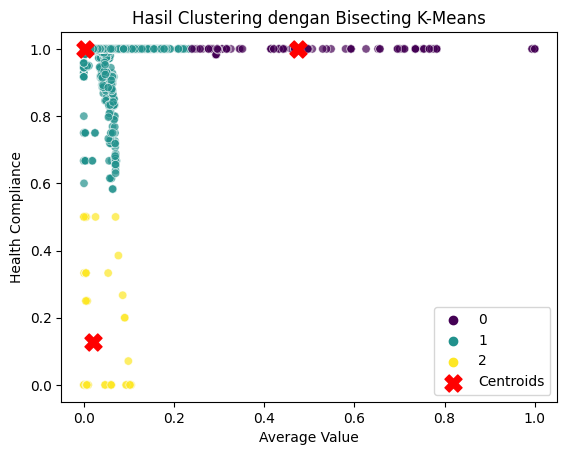

In [61]:
bskmdf = df
K = 3
# Pilih kolom yang akan digunakan untuk clustering
columns_for_clustering = ['average_value', 'health_compliance']

# Lakukan standardization pada fitur yang akan digunakan untuk clustering
scaler = MinMaxScaler()
bskmdf[columns_for_clustering] = scaler.fit_transform(bskmdf[columns_for_clustering])

# Pilih fitur-fitur yang akan digunakan untuk clustering
features_for_clustering = bskmdf[columns_for_clustering]

# Lakukan clustering dengan Bisecting K-Means
biskmeans = BisectingKMeans(n_clusters=K, random_state=42)
bskmdf['cluster'] = biskmeans.fit_predict(features_for_clustering)

# Plot hasil clustering
sns.scatterplot(x='average_value', y='health_compliance', data=bskmdf, hue='cluster', palette='viridis', alpha=0.7)
plt.scatter(biskmeans.cluster_centers_[:, 0], biskmeans.cluster_centers_[:, 1], c='red', marker='X', s=150, label='Centroids')
plt.title('Hasil Clustering dengan Bisecting K-Means')
plt.xlabel('Average Value')
plt.ylabel('Health Compliance')
plt.legend()
plt.show()

Untuk Hasil perbedaan K-Means Clustering dan Bisecting K-Means tidak terlalu terlihat dan dapat dikatakan similar. Dapat disimpulkan Clustering mendapatkan hasil cukup Optimal